# Why now is a great time for software engineers to start getting into quantum computer programming

Quantum computing may have been around as a subject for over 40 years now, but from the perspective of people dealing more with "computing" than "quantum", it's still usually considered a rare, obscure technology that "will change the world, one day, in 10 or 20 years." While it is hard not to notice progress if one is keeping even lightly in touch with the media, for majority of software and hardware developers out there these are single experiment's sucesses, rather than a real technology to be used today. Upon reading into the details, another milestone in QC often turns out to be a far cry from actual, large scale applications. And if it could already be useful, it's probably very custom, requiring a lot of knowledge and experience to do anything with.

But let's say that you, a developer, already got past this. Your excitement got greater than skepticism and you opened that Qiskit blog or Quantum Experience, or any other platform showing what can be done currently. That's much better than you thought, huh? There is plenty of simulators, as well as actual quantum machines that you can access with your code today. And the tools to use it are very friendly, it's not about hitting any endpoints from your terminal. This is fabulous, the future is here! But oh, wait, these are a few qubits at most. And the most advanced systems oscillate around a 100 physical qubits. And even these 5 cannot yet run a full-blown, long quantum circuit. Duh, 50 gates in a row may be too much? OK, this is exciting, but perhaps I should wait another few years for the hardware to get better. After all, what's the use of learning to write good software if the hardware for it simply does not allow it to be useful?

What if I told you that the advancements made in quantum computing today are _already_ coming both from hardware and software sides? Hardware still, of course, has a long and tricky way to go, but software is already playing a critical role. And you do not need a PhD in quantum physics or computing to understand it (though you, dear PhD's, are welcome too, of course.) Take Quantum Volume, for example. It is a metric created to essentially describe how good a quantum processor is, encompassing things like qubit decay time, single and multi-qubit gate errors, measuremet errors, cross talk and others into one simple number. In principle, quantum volume of N means that it is possible to reliably run a circuit of sqrt(n) qubits with sqrt(n) layers of gates. The higher the QV, the better, more reliable the processor is. Now for the good part: the current highest QV at the time of this writing is 128. Did you know that the latest two advances pushing QV further on an IBM processors were achieved through _software improvements_? Yep, the exact same hardware, quantum processor called Montreal, went from QV of 32 to 64 and then 128 through updates to the compiler and process controls. The point is, good code can literally result in higher fidelity that can be squeezed out of the same chip. Solid software can be the factor that enables an OK quantum chip to deliver incredible results. The hardware designers do have a lot of work and breakthroughs ahead (and you can get involved through Qiskit Metal), but the software engineers can already get creative and ensure their code is getting the most out of our hardware. Complaints that the chips are not good enough won't cut it.

Even without going too deep into understanding quantum compilation, let's look at a simple example. Imagine you have a quantum algorithm, for which you require a correct result to be returned at least 80% of the time to be deemed acceptable. Your task is based on a search problem, and you implement Grover's algorithm to solve it.

(If this example does not sounds or seem simple at all, please do not worry! I wanted to pick a problem real enough that it could be a part of a practical solution, while not more complex than going beyond some of the classic quantum algorithsm. Having said that, we all started sometime, and it's great to have you in our community! Qiskit textbook is a wonderful place to learn more about all the concepts I mention here, including the Grover algorithm itself, as well as circuit complexity. And you should still be able to get a grasp of the text below even without getting into the details of what the circuit is actually doing!)

In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ, BasicAer, QuantumRegister, ClassicalRegister
from qiskit.compiler import transpile
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
import random
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

# Grover algorithm in code

In [2]:
__author__ = "Kuba Pilch, 3yakuya"

class Circuit():
    database = None
    oracle = None
    results = None
    qc = None
    
    def __init__(self, database, oracle, results, qc):
        self.database = database
        self.oracle = oracle
        self.results = results
        self.qc = qc
    
    
    def extend(self, extension):
        self.qc = self.qc.combine(extension)
        pass


def initialize_circuit():
    database = QuantumRegister(3)
    oracle = QuantumRegister(1)
    results = ClassicalRegister(3)

    qc = QuantumCircuit(database, oracle, results)
    qc.h(database[:])
    
    circuit = Circuit(database, oracle, results, qc)
    return circuit


def initialize_oracle(circuit):
    qc = QuantumCircuit(circuit.database, circuit.oracle, circuit.results)
    qc.x(circuit.oracle[0])
    qc.h(circuit.oracle[0])
    return qc
    

def apply_oracle(circuit, searched_string):
    def apply_oracle_nots(qc, circuit, searched_string):
        for index, digit in enumerate(searched_string):
            if digit == "0":
                qc.x(circuit.database[index])

    qc = QuantumCircuit(circuit.database, circuit.oracle, circuit.results)
    apply_oracle_nots(qc, circuit, searched_string)
    qc.mct(circuit.database[0:3], circuit.oracle[0]) 
    apply_oracle_nots(qc, circuit, reversed(searched_string))
    return qc


def apply_diffusion(circuit):
    qc = QuantumCircuit(circuit.database, circuit.oracle, circuit.results)
    qc.h(circuit.database[:])
    qc.x(circuit.database[:])
    qc.h(circuit.database[2])
    qc.mct(circuit.database[0:2], circuit.database[2])
    qc.h(circuit.database[2])
    qc.x(circuit.database[:])
    qc.h(circuit.database[:])
    return qc


def measure_results(circuit):
    qc = QuantumCircuit(circuit.database, circuit.oracle, circuit.results)
    qc.measure(circuit.database, circuit.results)
    qc = qc.reverse_bits()
    return qc


def get_grover_circuit(diffusion_cycles, searched_string):
    circuit = initialize_circuit()
    circuit.extend(initialize_oracle(circuit))
    
    for diffusion_no in range(diffusion_cycles):
        circuit.extend(apply_oracle(circuit, searched_string))
        circuit.extend(apply_diffusion(circuit))

    circuit.extend(initialize_oracle(circuit).inverse())
    circuit.extend(measure_results(circuit))
    return circuit


def run_job(circuits, backend, shots_count):
    job = execute(circuits, backend=backend, shots=shots_count)
    return job


def retrieve_job(job_id, backend):
    job = backend.retrieve_job(job_id)
    return job


# Circuit generation and testing

<ipython-input-2-44328b2d10ea>:17: DeprecationWarning: The QuantumCircuit.combine() method is being deprecated. Use the compose() method which is more flexible w.r.t circuit register compatibility.
  self.qc = self.qc.combine(extension)


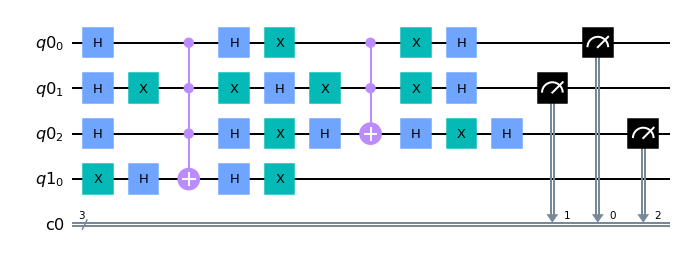

In [3]:
grover_circuit = get_grover_circuit(1, "101").qc
grover_circuit.draw(output='mpl')

So we write the code like above. We then generate a circuit in particular looking for element "10". We print it and look at its beauty; nice, clean and short circuit. Or is it?

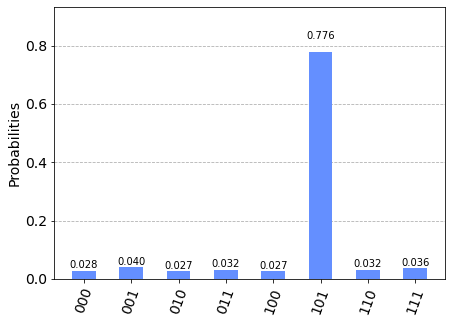

In [4]:
simulator = BasicAer.get_backend('qasm_simulator')
simulator_result = run_job(grover_circuit, simulator, 1024).result()
plot_histogram(simulator_result.get_counts())

It must be! In fact, the circuit is so simple that the `qasm_simulator` returns the expected result with over 75% probability! Let's run it on a real quantum machine and go change the world!

In [5]:
target_backend = provider.backend.ibmq_lima
seed = 10


def print_circuit_details(circuit):
    print("Circuit depth: ", circuit.depth())
    print("Operations: ", circuit.count_ops())
    return circuit.draw(output='mpl')

    
def get_optimized_circuit(optimization_level):
    optimized = transpile(grover_circuit, backend=target_backend, seed_transpiler=seed, optimization_level=optimization_level)
    return optimized


In [6]:
circuits = [
    get_optimized_circuit(0),
    get_optimized_circuit(1),
    get_optimized_circuit(2),
    get_optimized_circuit(3)
]


In [18]:
job = run_job(circuits, target_backend, 1024)
print(job.job_id())

607b0c58e1a9a10b0ed8d952


In [7]:
job_id = "607b0c58e1a9a10b0ed8d952"
RESULTS = retrieve_job(job_id, target_backend)

Circuit depth:  146
Operations:  OrderedDict([('rz', 117), ('sx', 78), ('cx', 41), ('x', 10), ('measure', 3), ('barrier', 1)])


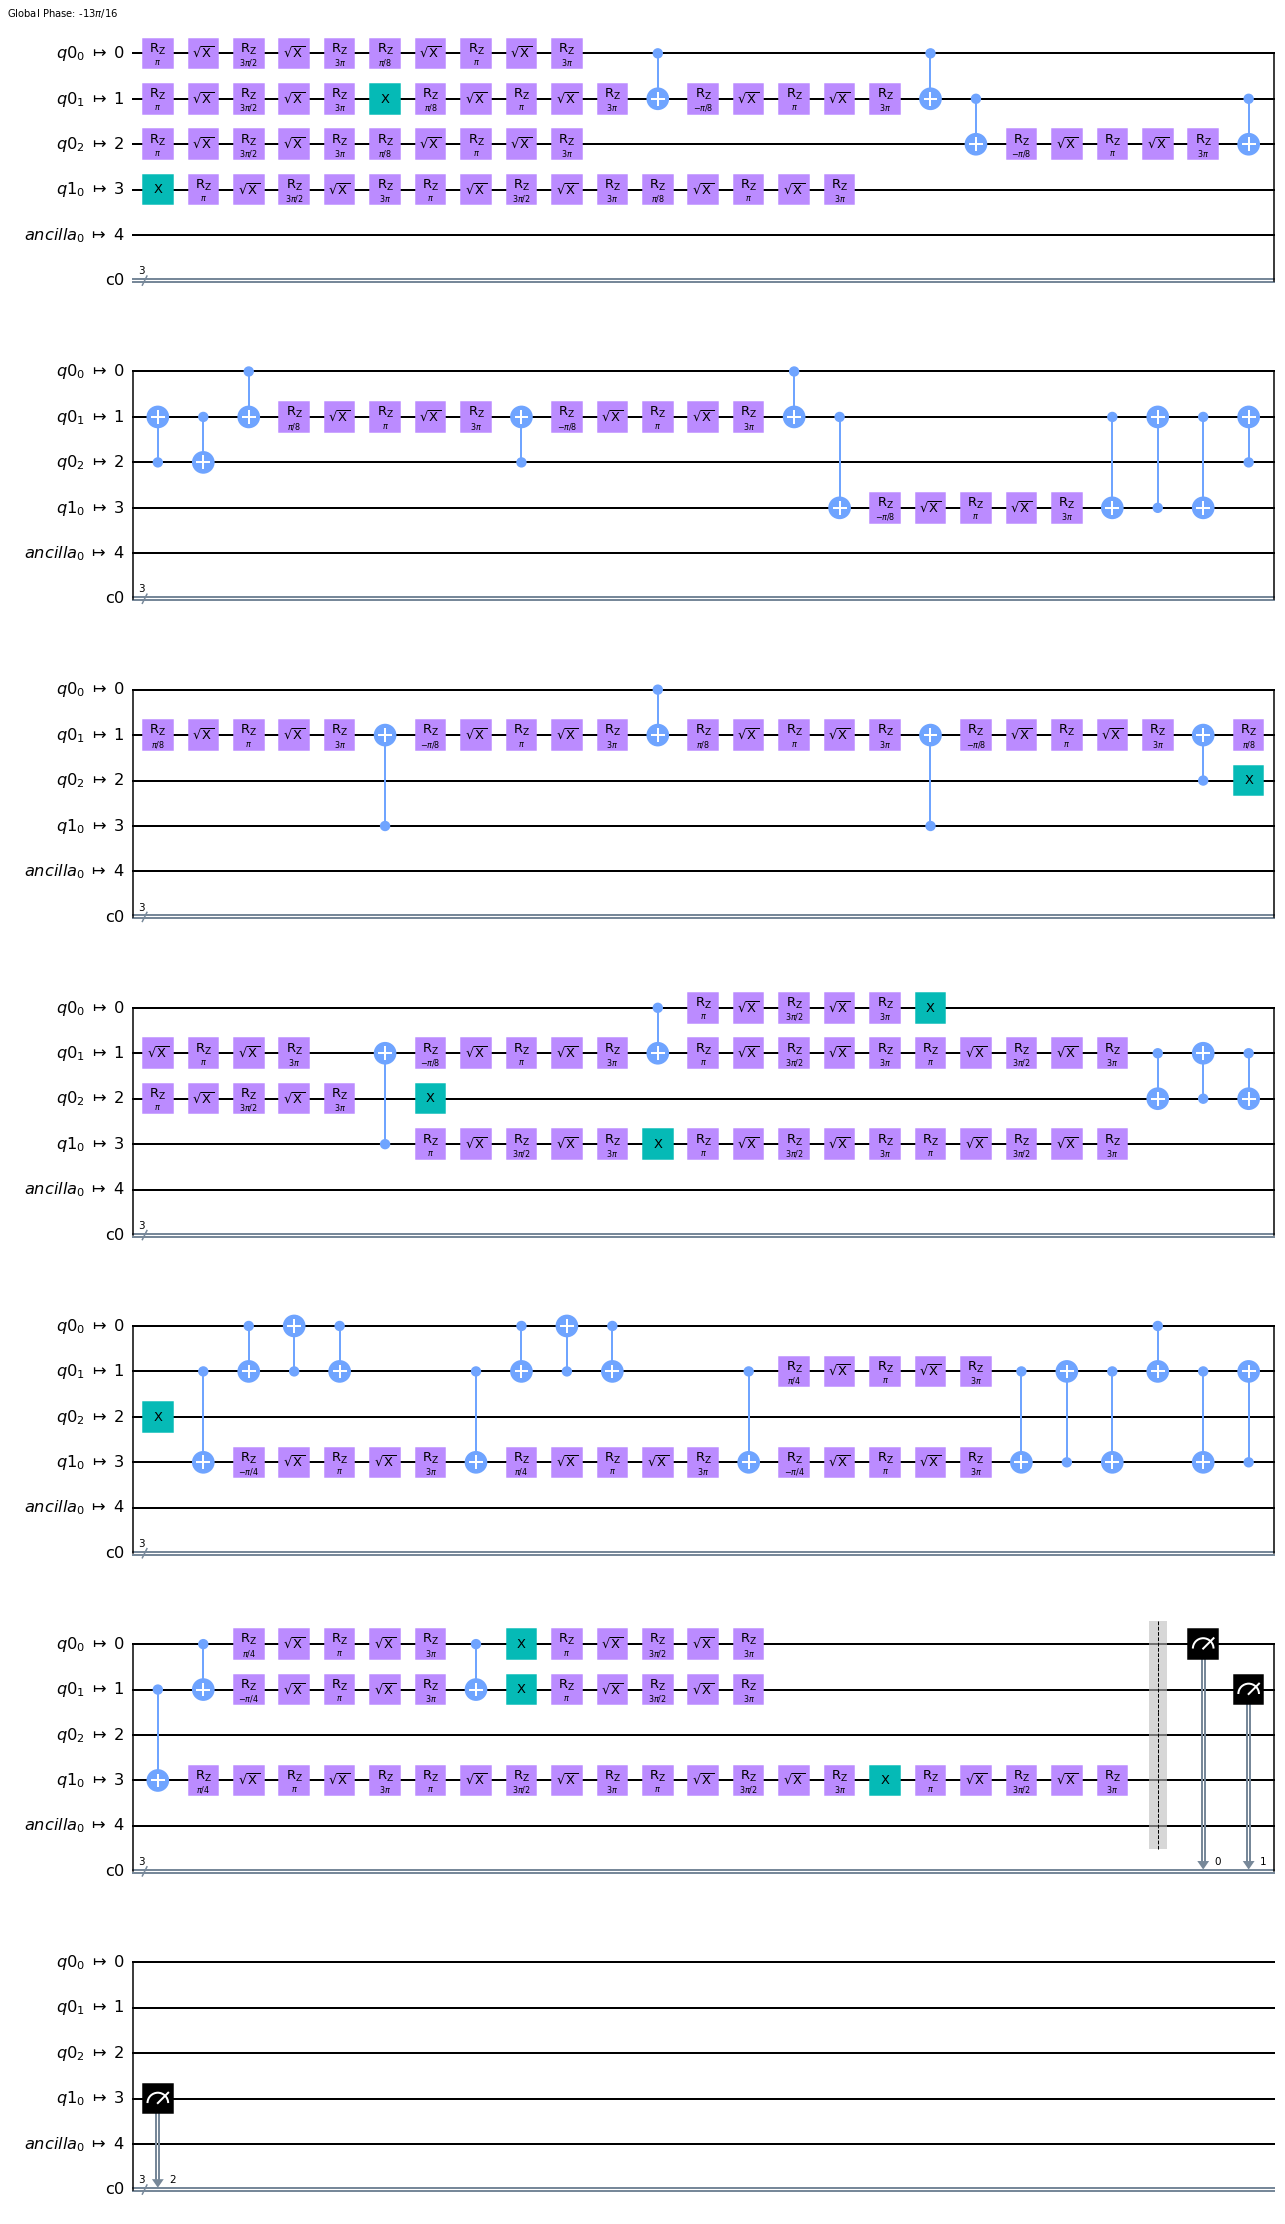

In [8]:
print_circuit_details(circuits[0])

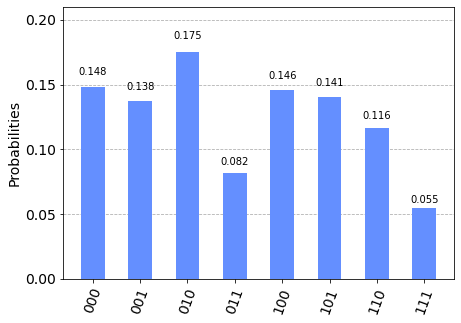

In [13]:
optimized_0_result = RESULTS.result().get_counts()[0]
plot_histogram(optimized_0_result)

As we see, in its simplest form our transpiled circuit is not... simple. With 146 circuit depth (gate layers), including 41 controlled-X gates, we are looking at some decently complex logic. And then the results look... pretty much random. Yeah, perhaps I need to wait for better hardware after all?

Not so fast! You are an engineer, remember? (And if you think you are not, you are working on software now, right? So you are a software engineer; great. Now, let's get back to work.) Perhaps our code can be optimized?

Let's go with the easiest way and ask the Qiskit optimizer to make the compiled circuit simpler for us with optimization level 1.

Circuit depth:  61
Operations:  OrderedDict([('cx', 41), ('rz', 37), ('sx', 11), ('measure', 3), ('x', 1), ('barrier', 1)])


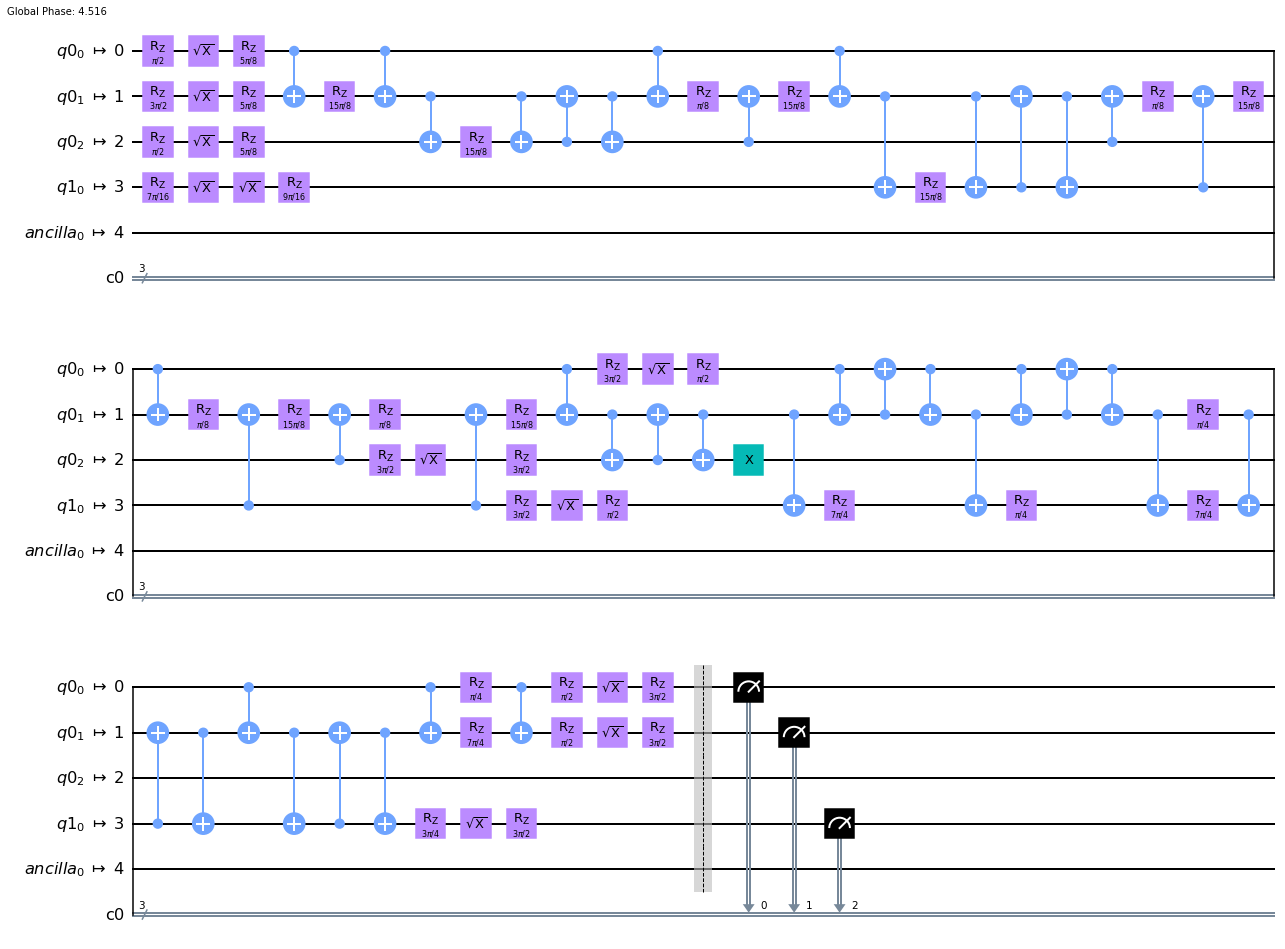

In [16]:
print_circuit_details(circuits[1])

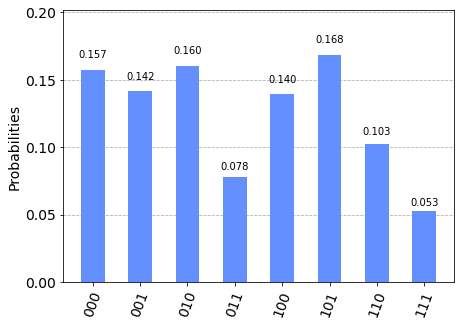

In [15]:
optimized_1_result = RESULTS.result().get_counts()[1]
plot_histogram(optimized_1_result)

Whoa, we cut the depth down to 61, though still with 41 CX gates. Let's run it!

The correct result is there, but barely peaking above others. It's not solid enough to trust... Let's keep our engineering going. Can we ask our optimizer to do more?

Circuit depth:  58
Operations:  OrderedDict([('cx', 36), ('rz', 35), ('sx', 11), ('measure', 3), ('x', 1), ('barrier', 1)])


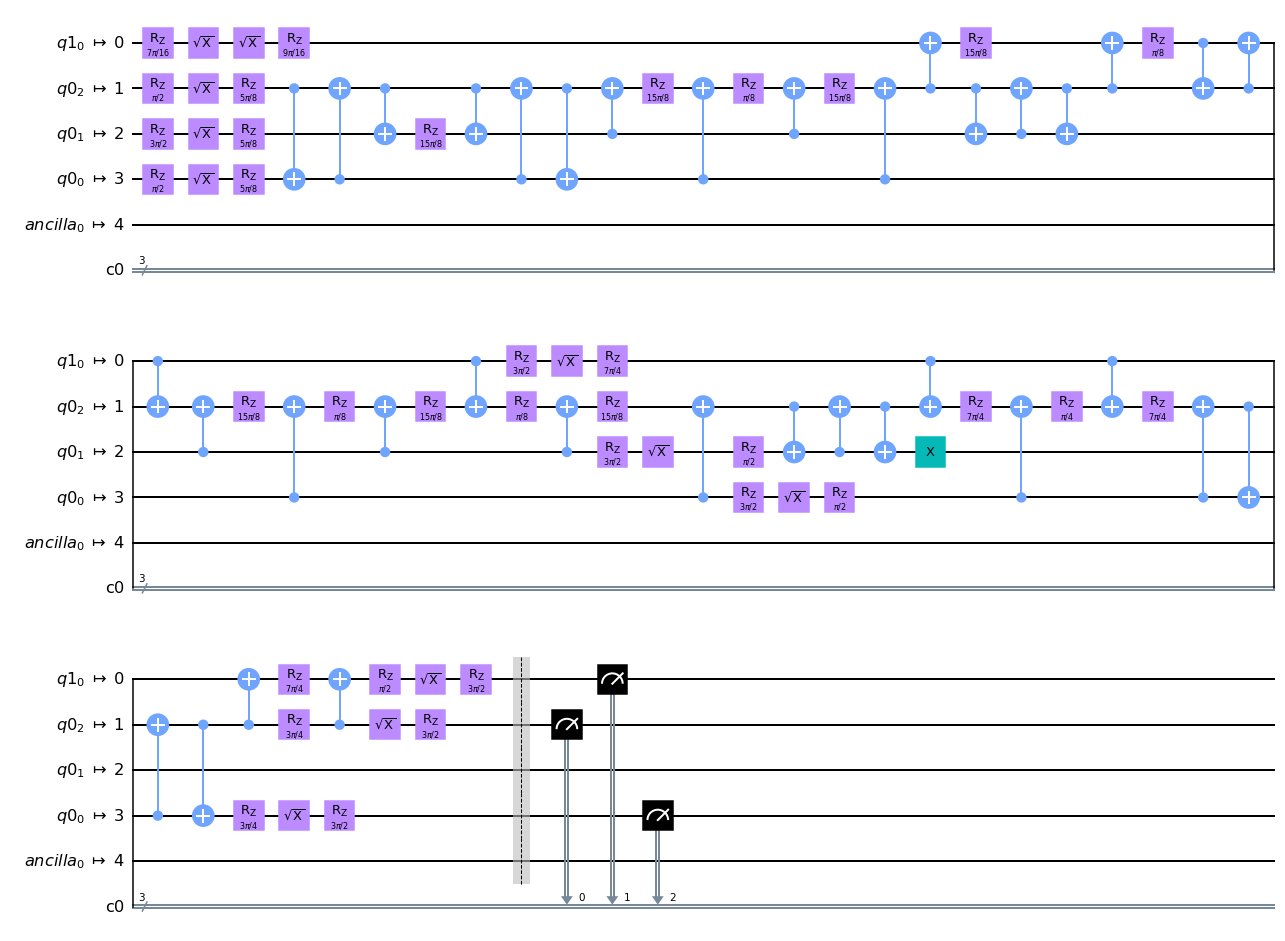

In [17]:
print_circuit_details(circuits[2])

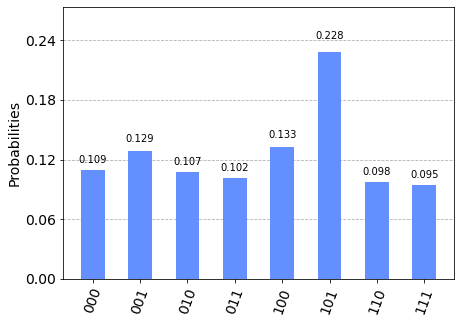

In [20]:
optimized_2_result = RESULTS.result().get_counts()[2]
plot_histogram(optimized_2_result)

OK depth got down slightly, to 58, but CX gates dropped to 36. Maybe some luck this time?

Ohh, it WORKS! We measured the correct results over 22% of the time, compared to 13% for the next most likely entry! I should not have doubted the optimizer... let's ask it for one more performance for us!

Circuit depth:  82
Operations:  OrderedDict([('rz', 52), ('sx', 34), ('cx', 34), ('measure', 3), ('x', 1), ('barrier', 1)])


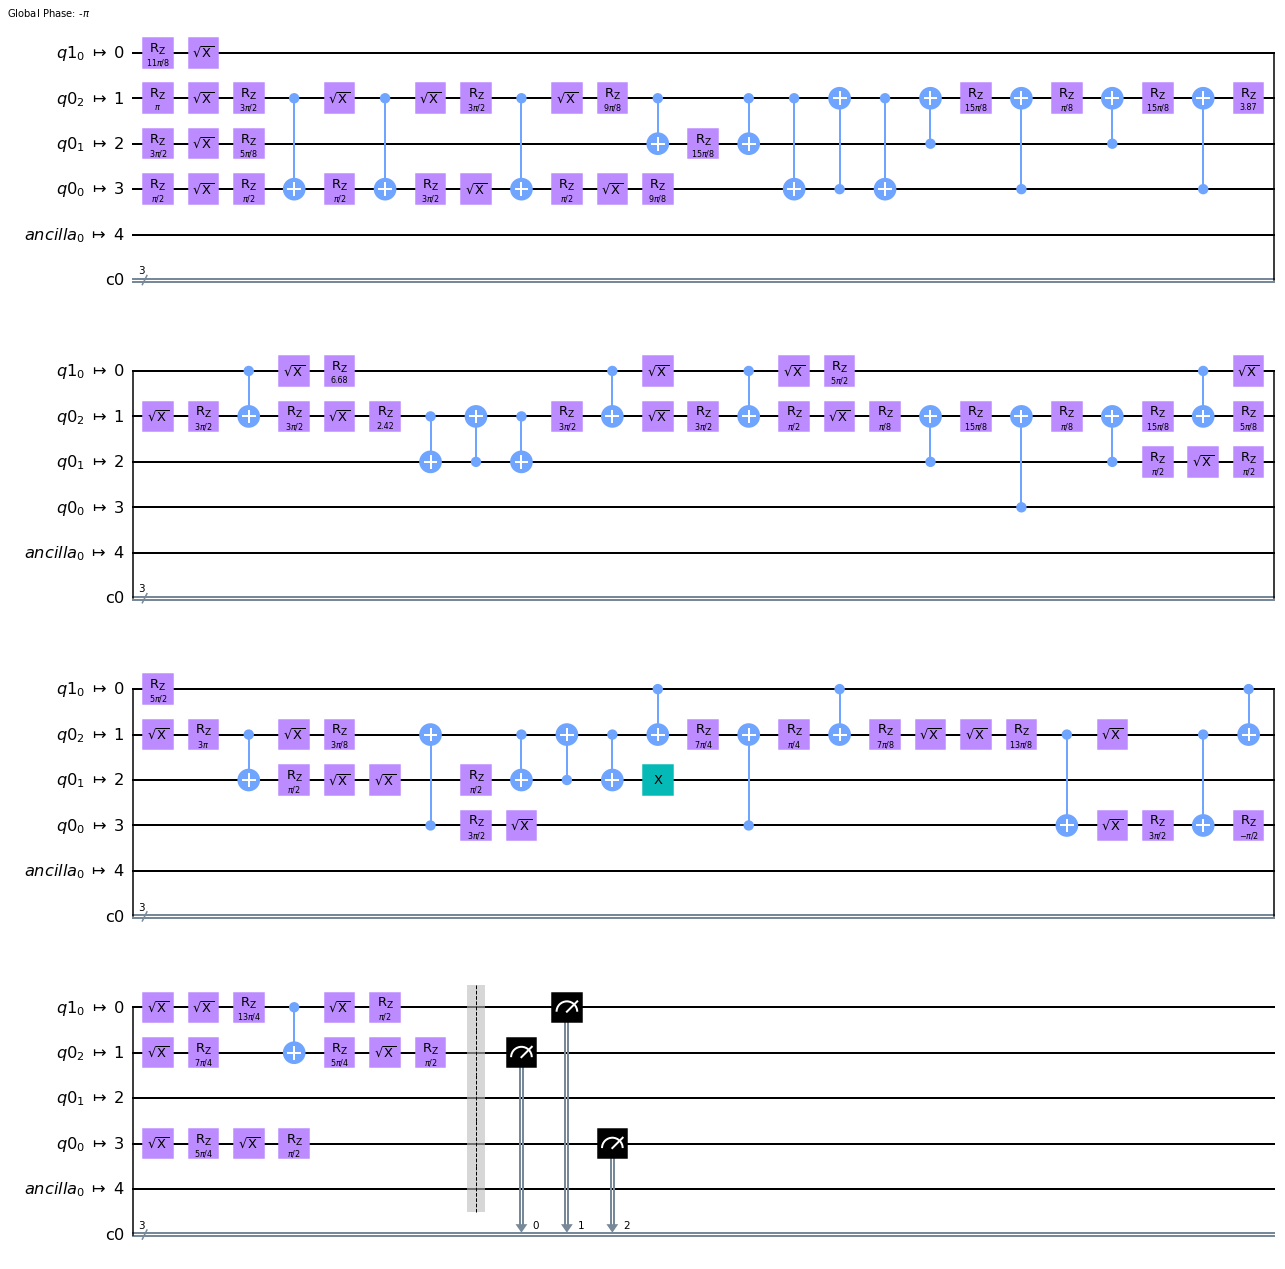

In [21]:
print_circuit_details(circuits[3])

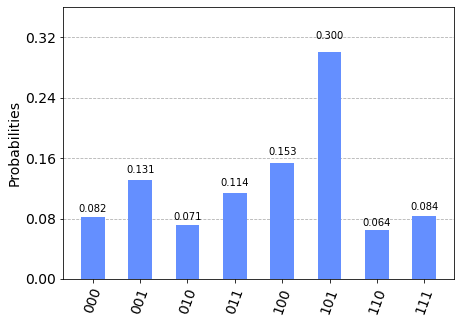

In [23]:
optimized_3_result = RESULTS.result().get_counts()[3]
plot_histogram(optimized_3_result)

Oh... well, maybe we pushed it too hard? Depth shoot up to 82, and 36 cXs is only slightly better than previous levels.

Run time... OK, 30% of the time we get the right answer, and the second most common result shows up 15% of the time. Let's re-run circuit with optimization levels 2 and 3 to get some additional data and then decide which one we shall use.

In [24]:
job_retesting_2_and_3 = run_job(circuits[2:4], target_backend, 2048)
print(job_retesting_2_and_3.job_id())

607b97294c1aae0fd0a94e49


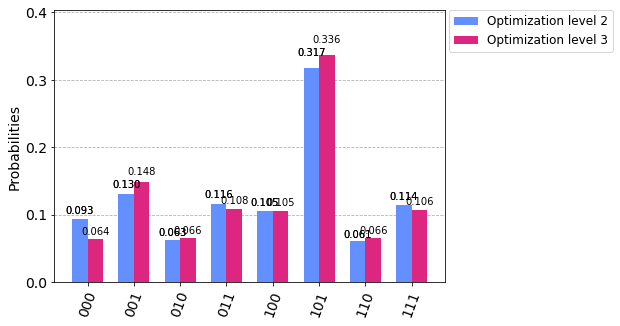

In [25]:
job_id_2 = "607b97294c1aae0fd0a94e49"
new_results = retrieve_job(job_id_2, target_backend)
plot_histogram(new_results.result().get_counts(), legend=["Optimization level 2", "Optimization level 3"])

OK,,, over 30% of the time the returned answer is correct for both optimization levels, and it is always the clear outlier! Either way, it appears we can rely on the solution to give a correct answer and should invest in it more. Look, we went through our results being a complete mess to some solid stats with just a bit of software improvements!

Even though our problem here is rather simplified, I hope this exercise highlights that we can significantly improve the quality of our results through software modifications, without any ingerence into hardware. 

It is a great time to start learning quantum code development precisely because software is already becoming a very important factor in the fidelity of the end results. Even though we are still eagerly awaiting, and hoping for, plenty of important hardware improvements before quantum computers take deeper, more critical role in real-world computing applications, we are already at a stage where the quality of our code can significantly impact our results. And if we learn the ropes now, writing solid code for today's quantum processors, our tomorrow's applications will be much useful much faster.

Oh, by the way... if you are by any chance into computing history, do you know that feeling when you hear about some old-school programmers? Like Dorothy Vaughan, Margaret Heafield Hamilton or Ellen Ullman? How awesome would it be to help the birth of technologies that changed the world so much, when they were still so young? Here is your chance, really. Except this time, hopefully, you do not have to fight so much biases, from racial to gender to education ones. No matter your backround, race or gender, you are welcome here. Come help program quantum computers today, and show 'em all how it's done!

In [26]:
import qiskit.tools.jupyter
%qiskit_version_table

In [27]:
# Jakub Kuba Pilch, '3yakuya', April 5th 2021, jfpilch@gmail.com